In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.optimize import check_grad 
from sklearn.linear_model import LogisticRegression
np.set_printoptions(precision=3)

## Curse of dimension ? How good is the gradient direction

In [5]:
n_samples, n_features = 500, 500
A = np.random.randn(n_samples, n_features)
b = np.random.randn(n_samples)

L = np.linalg.norm(A, ord=2) ** 2
def f(x):
    return 0.5 * norm(A @ x - b)**2

x0 = np.random.randn(n_features)

grad_increment = 1/L * A.T @ (A @ x0 - b)
f_grad = f(x0 - grad_increment)

Lets compare the objective values obtained by the gradient steps with the ones obtained by random directions (with same update magnitude).

In [6]:
fs = []
for _ in range(1000):
    direction = np.random.randn(n_features)
    direction *= norm(grad_increment) / norm(direction)
    
    fs.append(f(x0 - direction))

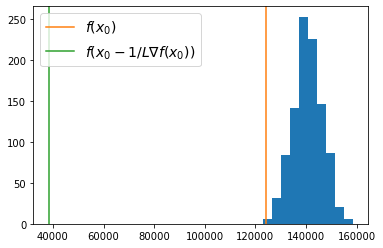

In [8]:
cmap = plt.get_cmap('tab10')
plt.hist(fs, bins=10)
plt.axvline(f(x0), label='$f(x_0)$', c=cmap(1))
plt.axvline(f_grad, label='$f(x_0 - 1/L \\nabla f(x_0))$', c=cmap(2))
plt.legend(loc='upper left', fontsize=14);

## GD on exponential function

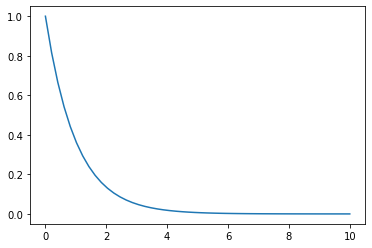

In [9]:
plt.plot(np.linspace(0, 10), np.exp(-np.linspace(0, 10)))

- Is the function $x \mapsto \exp(-x)$, restricted to $\mathbb{R}_+$ convex? Strongly convex? Smooth?
- And on $\mathbb{R}$ ?

In [10]:
x = 0
n_iter = 100000
objs = np.zeros(n_iter)
for t in range(n_iter):
    x = x + np.exp(-x)  # smoothness constant = sup_x f''(x) = 1  -> stepsize = 1 / 1
    objs[t] = np.exp(-x)

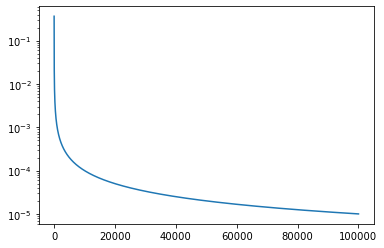

In [11]:
plt.semilogy(objs);

In [12]:
objs[[10, 100, 1000, 10_000, 99_000]]

array([7.363e-02, 9.559e-03, 9.943e-04, 9.993e-05, 1.010e-05])

As indicated by the $O(1/k)$ bound, we need roughly 10 times more iterations to get a 10 times better precision

## A small puzzle : least squares without strong convexity

A has 30 rows and 50 columns


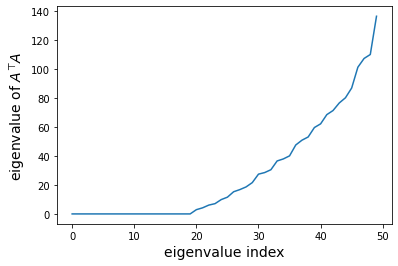

In [38]:
np.random.seed(0)
n_samples, n_features = 30, 50
b = np.random.randn(n_samples)
A = np.random.randn(n_samples, n_features)

print(f"A has {A.shape[0]} rows and {A.shape[1]} columns")

eigvals = np.linalg.eigvalsh(A.T @ A)
plt.plot(eigvals)
plt.xlabel("eigenvalue index", fontsize=14)
plt.ylabel("eigenvalue of $A^\\top A$", fontsize=14);

Is $x \mapsto \frac12 \Vert Ax - b \Vert^2$ strongly convex when $A$ has the spectrum above?

In [15]:
max_iter = 1000
L = norm(A, ord=2) ** 2
x = np.zeros(A.shape[1])
objs = []
for it in range(max_iter):
    x -= 1. / L * A.T @ (A @ x - b)
    objs.append(0.5 * norm(A @ x - b) ** 2)

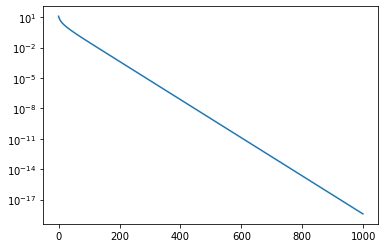

In [16]:
plt.semilogy(objs)

Why do observe a linear rate even though the objective is not strongly convex? 

## Logistic regression

For binary labels $b_i \in \{-1, 1\}$ and observations $a_i \in \mathbb{R}^d$, the *logistic regression* estimator is defined as the solution of:

$$ \min \sum_{i=1}^n \log (1 + \exp(- b_i a_i^\top x)) $$

Let's investigate gradient descent behavior on this objective function, on **separable** data.

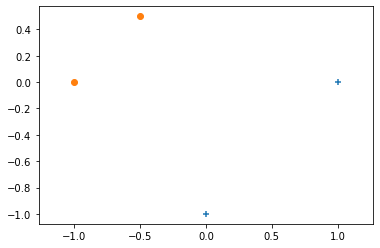

In [17]:
A = np.array([[-1, 0], 
              [-.5, .5],
              [0, -1], 
              [1, 0]])

b = np.array([1, 1, -1, -1])

for value, marker in zip([-1, 1], ["+", "o"]):
    points = b == value
    plt.scatter(A[points, 0], A[points, 1], marker=marker)
plt.axis("equal");

We see that there exists many hyperplanes separing exactly the data into positive and negative samples. This means that the iterates of GD will go to infinity, as the infimum of the loss (0) is not attained

The objective value and its gradient can be computed explicitely:  

In [18]:
def logistic_loss(x):
    return np.log(1. + np.exp(-b * (A @ x))).sum()

def grad_logistic_loss(x):
    return A.T @ (- b / (1. + np.exp(b * (A @ x))))

We check that our formula for the gradient is close to the one that `scipy` can compute with finite difference method:

In [19]:
check_grad(logistic_loss, grad_logistic_loss, np.random.randn(A.shape[1])) 
# norm of difference should be small 

1.4710649447521749e-08

The objective is smooth, with Lipschitz constant given by (see exercise sheet):

In [20]:
L = np.linalg.norm(A, ord=2) ** 2 / 4.

In [21]:
# GD algorithm:
def GD_logreg(stepsize=1/L, n_iter=20):
    x = np.ones(A.shape[1])
    all_x = np.zeros([n_iter, A.shape[1]])
    objs = []
    for it in range(n_iter):
        all_x[it] = x
        objs.append(logistic_loss(x))
        x -= stepsize * grad_logistic_loss(x)
    return x, all_x, objs

In [22]:
from ipywidgets import interact, FloatLogSlider

In [23]:
def plot_iterates(n_iter):
    n_iter = int(n_iter)
    x, all_x, objs = GD_logreg(1/L, n_iter)
    for value, marker in zip([-1, 1], ["+", "o"]):
        points = b == value
        plt.scatter(A[points, 0], A[points, 1], marker=marker)


    plt.scatter(all_x[:, 0], all_x[:, 1])
    plt.axis("equal");

interact(plot_iterates, n_iter=FloatLogSlider(base=2, step=1, min=0, max=15));

interactive(children=(FloatLogSlider(value=1.0, base=2.0, description='n_iter', max=15.0, step=1.0), Output())…

## GD on strongly convex Least Squares: another puzzle

In [24]:
n_samples, n_features = 500, 500
A = np.random.randn(n_samples, n_features)
b = np.random.randn(n_samples)

L = np.linalg.norm(A, ord=2) ** 2

In [27]:
max_iter = 3000
x0 = np.ones(n_features)
x = x0.copy()
objs = []
for it in range(max_iter):
    if it % 100 == 0:
        print(f'Iter {it}')
    x = x - 1. / L * A.T @ (A @ x - b)
    objs.append(norm(A @ x - b) ** 2 / 2)

Iter 0
Iter 100
Iter 200
Iter 300
Iter 400
Iter 500
Iter 600
Iter 700
Iter 800
Iter 900
Iter 1000
Iter 1100
Iter 1200
Iter 1300
Iter 1400
Iter 1500
Iter 1600
Iter 1700
Iter 1800
Iter 1900
Iter 2000
Iter 2100
Iter 2200
Iter 2300
Iter 2400
Iter 2500
Iter 2600
Iter 2700
Iter 2800
Iter 2900


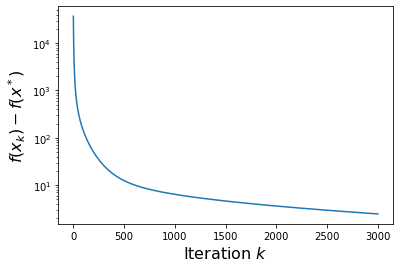

In [28]:
plt.semilogy(objs)
plt.xlabel("Iteration $k$", fontsize=16)
plt.ylabel("$f(x_k) - f(x^*)$", fontsize=16);

In [30]:
eigvals = np.linalg.eigvalsh(A.T @ A)

In [31]:
kappa = eigvals[-1] / eigvals[0]
print(kappa)

3461777.377937051


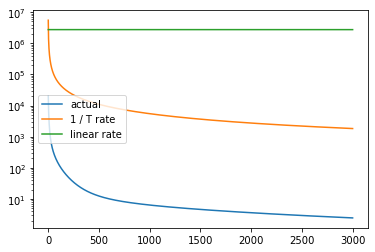

In [32]:
x_star = np.linalg.solve(A, b)
it = np.arange(1, max_iter)
plt.semilogy(it, objs[1:], label='actual')
plt.semilogy(it, 2 * L * norm(x0 - x_star)  ** 2 / it, label='1 / T rate')
plt.semilogy(it, L * norm(x0 - x_star) ** 2 * np.exp(- it / kappa), label='linear rate')
plt.legend()

$\hookrightarrow$ The condition number is huge, and the constants make the 1/k rate better than the linear one.

## Nesterov accelerated gradient (momentum)


In [40]:
n_samples, n_features = 400, 500
np.random.seed(0)
A = np.random.randn(n_samples, n_features)
b = np.random.randn(n_samples)

n_iter = 10000
L = np.linalg.norm(A, ord=2) ** 2

t = 1
x = np.ones(n_features)
y = x.copy()
x_gd = x.copy()

objs_agd = np.zeros(n_iter)
objs_gd = np.zeros(n_iter)

for it in range(n_iter):
    t_old = t
    x_old = x
    
    x = y - 1/L * A.T @ (A @ y - b)
    t = (1 + np.sqrt(1 + 4 * t ** 2)) / 2
    y = x + (t_old - 1) / t * (x - x_old) 
    objs_agd[it] = 0.5 * norm(A @ x - b) ** 2
    
    x_gd -= 1/L * A.T @ (A @ x_gd - b)
    objs_gd[it] = norm(A @ x_gd - b) ** 2 / 2

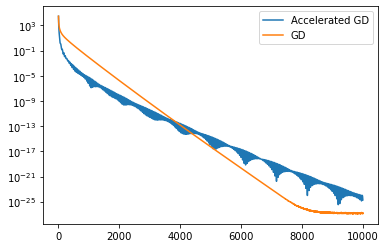

In [41]:
plt.semilogy(objs_agd, label="Accelerated GD")
plt.semilogy(objs_gd, label="GD")
plt.legend()

**Exercise**: increase to the number of iteration to 5000 and check the behavior.